In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load Data
df = pd.read_excel('mpuData.xlsx')

# Clean Names
df['Movement_Name'] = df['Movement_Name'].str.lower().str.strip()

# Define Attempt ID: Every 32 rows (8 readings * 4 joints) is 1 Attempt
rows_per_attempt = 32
df['Attempt_ID'] = np.arange(len(df)) // rows_per_attempt

print(f"Total rows: {len(df)} | Total Attempts: {len(df)//rows_per_attempt}")

Total rows: 628 | Total Attempts: 19


In [4]:
def extract_attempt_features(group):
    features = {}
    # Targets
    features['target_movement'] = group['Movement_Name'].iloc[0]
    features['target_correctness'] = group['Label_Value'].iloc[0]
    
    # Process each joint (Shoulder, Elbow, Wrist, Hand)
    for joint in ['shoulder', 'elbow', 'wrist', 'hand']:
        joint_data = group[group['Joint_Label'].str.lower() == joint]
        
        for col in ['Pitch', 'Roll', 'AccelX', 'AccelY', 'AccelZ']:
            # Mean: General position
            features[f'{joint}_{col}_mean'] = joint_data[col].mean()
            # Std: Vibration/Shaking (Key for detecting False movements)
            features[f'{joint}_{col}_std'] = joint_data[col].std()
            # Range: Total range of motion
            features[f'{joint}_{col}_range'] = joint_data[col].max() - joint_data[col].min()
            
    return pd.Series(features)

# Apply extraction
final_data = df.groupby('Attempt_ID').apply(extract_attempt_features).reset_index(drop=True)
print("New Data Shape (Per Attempt):", final_data.shape)

New Data Shape (Per Attempt): (20, 62)


In [5]:
# Encode Targets
le_move = LabelEncoder()
y_move = le_move.fit_transform(final_data['target_movement'])
y_corr = final_data['target_correctness'].astype(int)

# Features
X = final_data.drop(['target_movement', 'target_correctness'], axis=1)

# Split (using 25% for test to have enough samples)
X_train, X_test, ym_train, ym_test, yc_train, yc_test = train_test_split(
    X, y_move, y_corr, test_size=0.25, stratify=y_move, random_state=42
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

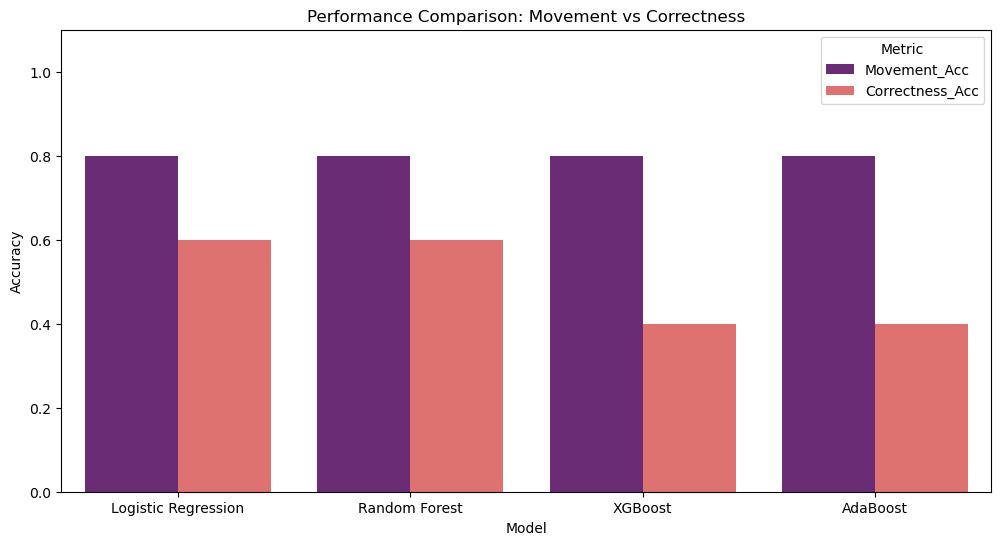

                 Model  Movement_Acc  Correctness_Acc
0  Logistic Regression           0.8              0.6
1        Random Forest           0.8              0.6
2              XGBoost           0.8              0.4
3             AdaBoost           0.8              0.4


In [6]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

results = []

for name, model in models.items():
    # 1. Train for Movement Type
    model.fit(X_train_scaled, ym_train)
    m_acc = accuracy_score(ym_test, model.predict(X_test_scaled))
    
    # 2. Train for Correctness
    model.fit(X_train_scaled, yc_train)
    c_acc = accuracy_score(yc_test, model.predict(X_test_scaled))
    
    results.append({'Model': name, 'Movement_Acc': m_acc, 'Correctness_Acc': c_acc})

# Create Results DataFrame
results_df = pd.DataFrame(results)

# --- VISUALIZATION ---
plt.figure(figsize=(12, 6))
melted_df = results_df.melt(id_vars='Model', var_name='Metric', value_name='Accuracy')
sns.barplot(data=melted_df, x='Model', y='Accuracy', hue='Metric', palette='magma')
plt.title('Performance Comparison: Movement vs Correctness')
plt.ylim(0, 1.1)
plt.show()

print(results_df)